### Loading libraries and dependencies

In [1]:
#specify the packages of interest
options(warn=-1)
options(repr.plot.width=6, repr.plot.height=4)

packages = c("tidyverse", "splines", "nlme")

## Check to see if package is available and load else install the package and its dependencies
package.check <- lapply(packages, FUN = function(x) {
  if (!require(x, character.only = TRUE)) {
    install.packages(x, dependencies = TRUE)
    library(x, character.only = TRUE)
  }
})

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: splines
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse



In [2]:
#loading the data
stemcell <- read.table("data/stemcell.txt", col.names = "order")

In [3]:
#Implement a function that depends on the response, covariate, number of knots and
# spline degree that calculate a regression spline fit for f.

spline_regression <- function(Y, X, k, deg){
  # Y: response
  # X: covariate
  # k: number of knots
  # deg: degree of spline = order - 1 of spline
  
  m <- deg + 1 #order
  
  # Determine knots (as a vector) = equidistant partion of domain of X 
  knots = seq(min(X), max(X), length.out = k+2)
  knots = c(min(X) - (m-1):1 , knots, max(X) + 1:(m-1)) # In order to consider inner knots, see ?spline.des
  
  #Basis matrix for B-splines
  N <- spline.des(knots, X, ord = m)$design
  
  # Calculate least squares of Y as fitted by N for beta
  beta <- lm(Y ~ N - 1)$coefficients #we get rid of the intercept with the -1
  
  # Define regression spline
  f.hat <- function(x){
    n <- spline.des(knots, x, ord = m,  outer.ok = TRUE)$design
    as.numeric(n %*% beta)
  }
    
  return(f.hat)
}

In [4]:
#We fix the spline degree to 2 and estimate f with different number of knots
Y <- stemcell$order
X <- seq(10, 1440, 10) # Measurements every 10 minutes for 24 hours

# Estimated splines for f for different number of knots
f.fit.knot1 <- spline_regression(Y, X, 3, deg = 2)
f.fit.knot2 <- spline_regression(Y, X, 14, deg = 2)
f.fit.knot3 <- spline_regression(Y, X, 22, deg = 2)
f.fit.knot4 <- spline_regression(Y, X, 31, deg = 2)

# Plot all resulting fits on one plot
Time = seq(10, 1440, 1)
df1 <- data.frame(x = Time, y = f.fit.knot1(Time))
df2 <- data.frame(x = Time, y = f.fit.knot2(Time))
df3 <- data.frame(x = Time, y = f.fit.knot3(Time))
df4 <- data.frame(x = Time, y = f.fit.knot4(Time))


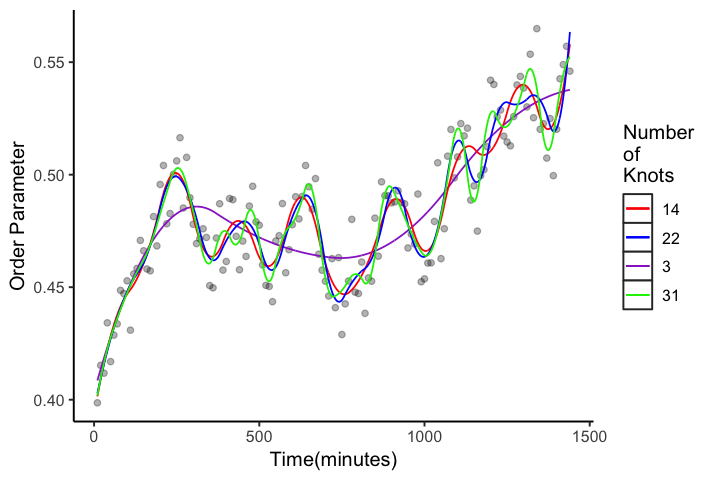

In [5]:
ggplot(data = data.frame(x = X, y = Y), aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  geom_line(data = df1, aes(color = "3")) +
  geom_line(data = df2, aes(color = "14")) +
  geom_line(data = df3, aes(color = "22")) +
  geom_line(data = df4, aes(color = "31")) +
  scale_colour_manual(name = "Number \nof \nKnots", values = c("red", "blue", "darkorchid", "green2")) +
  xlab("Time(minutes)") +
  ylab("Order Parameter") +
  theme_classic(base_size = 12) + #font size
  theme(legend.key = element_rect(fill = "white", colour = "gray19"))  #legend keys editing

In [6]:
# Fix the number of knots to 4, estimate f using splines of degree
# from 1 to 4 and plot all obtained fits on one plot
f.fit.deg1 <- spline_regression(Y, X, 4, deg = 1)
f.fit.deg2 <- spline_regression(Y, X, 4, deg = 2)
f.fit.deg3 <- spline_regression(Y, X, 4, deg = 3)
f.fit.deg4 <- spline_regression(Y, X, 4, deg = 4)

# Plot all resulting fits on one plot
#First, the dataframes for ggplot2
df5 <- data.frame(x = Time, y = f.fit.deg1(Time))
df6 <- data.frame(x = Time, y = f.fit.deg2(Time))
df7 <- data.frame(x = Time, y = f.fit.deg3(Time))
df8 <- data.frame(x = Time, y = f.fit.deg4(Time))

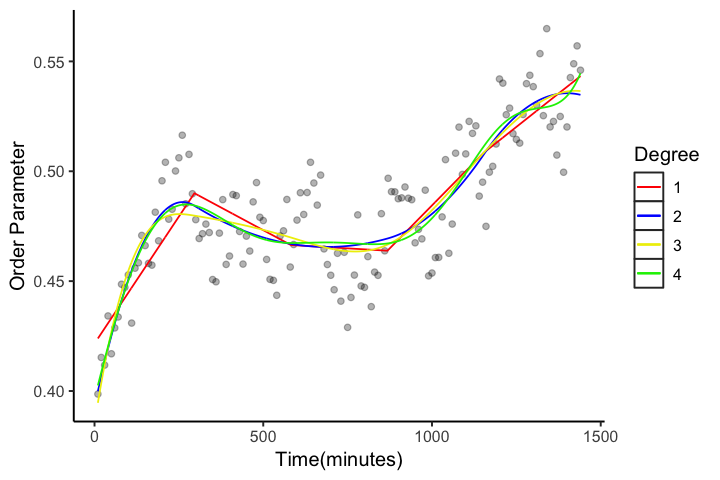

In [7]:
#The plot
ggplot(data = data.frame(x = X, y = Y), aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  geom_line(data = df5, aes(color = "1")) +
  geom_line(data = df6, aes(color = "2")) +
  geom_line(data = df7, aes(color = "3")) +
  geom_line(data = df8, aes(color = "4")) +
  scale_colour_manual(name = "Degree", values = c("red", "blue", "yellow2", "green2")) +
  xlab("Time(minutes)") +
  ylab("Order Parameter") +
  theme_classic(base_size = 12) + #font size
  theme(legend.key = element_rect(fill = "white", colour = "gray19"))  #legend keys editing

In [8]:
#Question(b)

#Implement the GCV, then the function that estimates the optimal number of equidistant knots 

#Objective function to minimize (over number of knots k)
GCV <- function(k, deg){
  f.fitted <- spline_regression(Y, X, k, deg = deg)
  f.fitted <- f.fitted(X)
  
  a <- norm(Y - f.fitted, type = "2")
  n <- length(Y)
  
  res <- (a**2)/(1 - k/n)**2
  
  return(res)
}
#Vectorize the GCV
GCV <- Vectorize(GCV, vectorize.args = c("k"))

#Optimise over k for degrees 1 to 4
max.k <- 50

opt_k_deg1 <- which(GCV(1:max.k, deg = 1) == min(GCV(1:max.k, deg = 1)))
opt_k_deg2 <- which(GCV(1:max.k, deg = 2) == min(GCV(1:max.k, deg = 2)))
opt_k_deg3 <- which(GCV(1:max.k, deg = 3) == min(GCV(1:max.k, deg = 3)))
opt_k_deg4 <- which(GCV(1:max.k, deg = 4) == min(GCV(1:max.k, deg = 4)))

df_opt_k <- data.frame(deg1 = opt_k_deg1, deg2 = opt_k_deg2,
                       deg3 = opt_k_deg3, deg4 = opt_k_deg4)
row.names(df_opt_k) <- "Opt GCV knot number"
df_opt_k

# Calculate fits with GCV knots number, for degrees 1 to 4
f_fit_GCV1 <- spline_regression(Y, X, k = opt_k_deg1, deg = 1)
f_fit_GCV2 <- spline_regression(Y, X, k = opt_k_deg2, deg = 2)
f_fit_GCV3 <- spline_regression(Y, X, k = opt_k_deg3, deg = 3)
f_fit_GCV4 <- spline_regression(Y, X, k = opt_k_deg4, deg = 4)

# Plot resulting estimators on one plot
#Dataframes for ggplot
df9 <- data.frame(x = Time, y = f_fit_GCV1(Time))
df10 <- data.frame(x = Time, y = f_fit_GCV2(Time))
df11 <- data.frame(x = Time, y = f_fit_GCV3(Time))
df12 <- data.frame(x = Time, y = f_fit_GCV4(Time))

,deg1,deg2,deg3,deg4
Opt GCV knot number,29,33,35,21


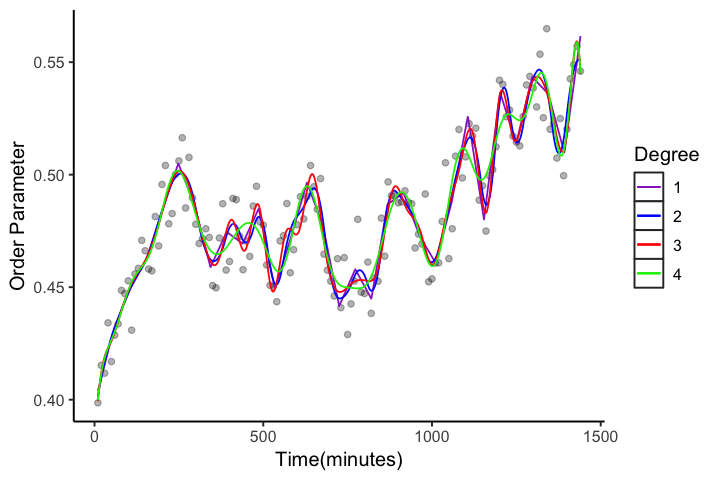

In [9]:
#plot
ggplot(data = data.frame(x = X, y = Y), aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  geom_line(data = df9, aes(color = "1")) +
  geom_line(data = df10, aes(color = "2")) +
  geom_line(data = df11, aes(color = "3")) +
  geom_line(data = df12, aes(color = "4")) +
  scale_colour_manual(name = "Degree",  values = c("darkorchid", "blue", "red", "green2")) +
  xlab("Time(minutes)") +
  ylab("Order Parameter") +
  theme_classic(base_size = 12) + #font size
  theme(legend.key = element_rect(fill = "white", colour = "gray19"))  #legend keys editing

In [10]:
#Question(c)

#Update function for regression splines so that it takes into account that 
#the errors follow an autoregressive process of order one

spline_autoregressive <- function(Y, X, k, deg){
  #Y: response
  #X: covariate
  #k: number of knots
  #deg: degree of spline = order-1 of spline
  
  m = deg + 1 #order
  
  # Determine knot points (equidistant partion of domain of X)
  knots = seq(min(X), max(X), length.out = k+2)
  knots = c(min(X) - (m-1):1 , knots, max(X) + 1:(m-1)) #In order to take inner knots. Check ?spline.des
  
  # Basis matrix of B-splines
  N = spline.des(knots, X, ord = m)$design
  
  # Implement autoregressive process of order 1 to the fit ("rescale the fit")
  a = 0.55
  n = length(Y)
  R = toeplitz(a**(0:(n-1)))
  R.inverse = solve(R)
  NRN = t(N) %*% R.inverse %*% N
  NRY = t(N) %*% R.inverse %*% Y
  M = solve(NRN) %*% NRY
  
  #Regression spline
  f.hat = function(x){
    #B-splines evaluated at x
    n = spline.des(knots, x, ord = m,  outer.ok = TRUE)$design
    as.numeric(n %*% M)
  }
  return(f.hat)
}

In [11]:
#Update function for GCV so that it takes into account that 
#the errors follow an autoregressive process of order one

GCV_auto <- function(k, deg){
  f_fitted = spline_autoregressive(Y, X, k, deg = deg)
  f_fitted = f_fitted(X)
  
  a = 0.55
  n = length(Y)
  R = toeplitz(a**(0:(n-1)))
  R.inverse <- solve(R)
  
  aux = t(Y - f_fitted) %*% R.inverse %*% (Y - f_fitted)
  n = length(Y)
  
  res = aux/(1 - k/n)**2
  
  return(res)
}

GCV_auto <- Vectorize(GCV_auto, vectorize.args = c("k"))

# Optimise over k for degrees 1 to 4 for the updated model
opt.k.deg1.auto <- which(GCV_auto(1:max.k, deg = 1) == min(GCV_auto(1:max.k, deg = 1)))
opt.k.deg2.auto <- which(GCV_auto(1:max.k, deg = 2) == min(GCV_auto(1:max.k, deg = 2)))
opt.k.deg3.auto <- which(GCV_auto(1:max.k, deg = 3) == min(GCV_auto(1:max.k, deg = 3)))
opt.k.deg4.auto <- which(GCV_auto(1:max.k, deg = 4) == min(GCV_auto(1:max.k, deg = 4)))

df_opt_k_auto <- data.frame(deg1 = opt.k.deg1.auto, deg2 = opt.k.deg2.auto,
                            deg3 = opt.k.deg3.auto, deg4 = opt.k.deg4.auto)
row.names(df_opt_k_auto) <- "Opt GCV knot number (autoregressive)"
df_opt_k_auto

# Calculate estimators with knot numbers from the updated GCV for degrees 1 to 4
f_fit_auto1 <- spline_autoregressive(Y, X, k = opt.k.deg1.auto, deg = 1)
f_fit_auto2 <- spline_autoregressive(Y, X, k = opt.k.deg2.auto, deg = 2)
f_fit_auto3 <- spline_autoregressive(Y, X, k = opt.k.deg3.auto, deg = 3)
f_fit_auto4 <- spline_autoregressive(Y, X, k = opt.k.deg4.auto, deg = 4)

# Plot resulting estimators on one plot
#First, dataframes for ggplot
df13 <- data.frame(x = Time, y = f_fit_auto1(Time))
df14 <- data.frame(x = Time, y = f_fit_auto2(Time))
df15 <- data.frame(x = Time, y = f_fit_auto3(Time))
df16 <- data.frame(x = Time, y = f_fit_auto4(Time))

,deg1,deg2,deg3,deg4
Opt GCV knot number (autoregressive),6,3,1,1


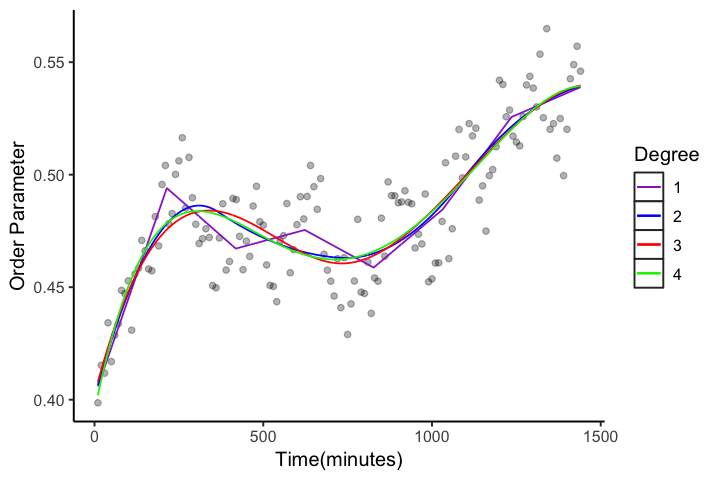

In [12]:
#Plot
ggplot(data = data.frame(x = X, y = Y), aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  geom_line(data = df13, aes(color = "1")) +
  geom_line(data = df14, aes(color = "2")) +
  geom_line(data = df15, aes(color = "3")) +
  geom_line(data = df16, aes(color = "4")) +
  scale_colour_manual(name = "Degree", values = c("darkorchid", "blue", "red", "green2")) +
  xlab("Time(minutes)") +
  ylab("Order Parameter") +
  theme_classic(base_size = 12) + #font size
  theme(legend.key = element_rect(fill = "white", colour = "gray19"))  #legend keys editing

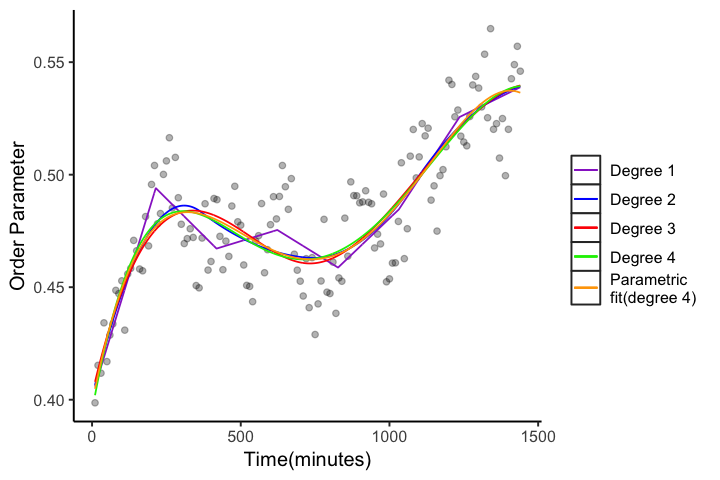

In [13]:
# Fit parametric model of degree 4
model1 <- gls(Y ~ X + I(X**2) + I(X**3) + I(X**4), correlation = corAR1(0.55))

polynomial.fit1 <- function(x){ as.numeric(model1$coefficients %*% x**(0:4)) }
polynomial.fit1 <- Vectorize(polynomial.fit1)

ggplot(data = data.frame(x = X, y = Y), aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  geom_line(data = df13, aes(color = "Degree 1")) +
  geom_line(data = df14, aes(color = "Degree 2")) +
  geom_line(data = df15, aes(color = "Degree 3")) +
  geom_line(data = df16, aes(color = "Degree 4")) +
  stat_function(fun = polynomial.fit1, aes(color = "Parametric \nfit(degree 4)")) +
  scale_colour_manual(name = "", values = c("darkorchid", "blue", "red", "green2", "orange")) +
  xlab("Time(minutes)") +
  ylab("Order Parameter") +
  theme_classic(base_size = 12) + #font size
  theme(legend.key = element_rect(fill = "white", colour = "gray19"))  #legend keys editing

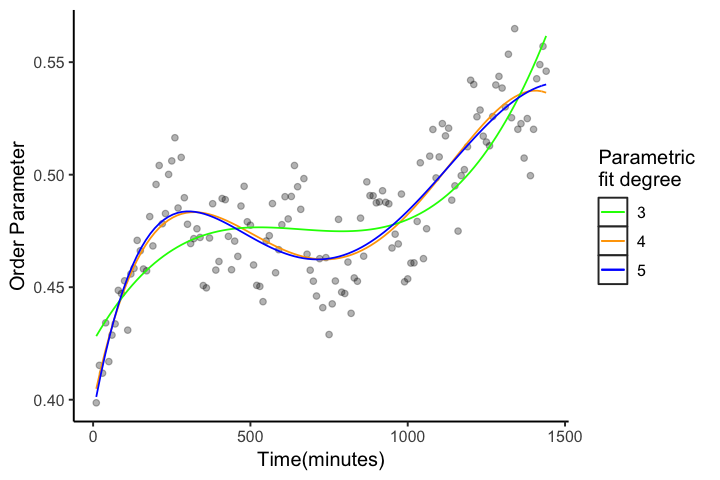

In [14]:
# For degree 3 and 5
model2 <- gls(Y ~ X + I(X**2) + I(X**3), correlation = corAR1(0.55))
model3 <- gls(Y ~ X + I(X**2) + I(X**3) + I(X**4) + I(X**5), correlation = corAR1(0.55))

polynomial.fit2 <- function(x){ as.numeric(model2$coefficients %*% x**(0:3)) }
polynomial.fit3 <- function(x){ as.numeric(model3$coefficients %*% x**(0:5)) }
polynomial.fit2 <- Vectorize(polynomial.fit2)
polynomial.fit3 <- Vectorize(polynomial.fit3)

ggplot(data = data.frame(x = X, y = Y), aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  stat_function(fun = polynomial.fit1, aes(color = "4")) +
  stat_function(fun = polynomial.fit2, aes(color = "3")) +
  stat_function(fun = polynomial.fit3, aes(color = "5")) + 
  scale_colour_manual(name = "Parametric \nfit degree ", values = c("green", "orange","blue")) +
  xlab("Time(minutes)") +
  ylab("Order Parameter") +
  theme_classic(base_size = 12) + #font size
  theme(legend.key = element_rect(fill = "white", colour = "gray19"))  #legend keys editing